## Tronc Data Modeling Take Home Test: 

## Predicting the Performance of Facebook Posts

This noteboook walks through a first iteration of attempting to predict the 'success' of facebook posts. We proxy success by using 'post_impressions_organic_unique' insights, and develop a feature space by processing the textual components of the post using TF_IDF Vectorization and  Latent Dirichlet Allocation (LDA) into a vector expressing the probabilistic relevance to a set of known 'topics.' The intuition is that certain topics will draw more interest than others and hence more shares and subsequent impressions.

We will fit a Random Forest model to the transformed dataset and collect standard regression metrics such as Explained Variance and Mean Squared Error. 

### Libraries Used:

- numpy
- pandas
- matplotlib
- nltk
- scipy
- sklearn
- nltk (requires corpus download - 'nltk.download()')


Some imports:

In [182]:
% matplotlib inline
from __future__ import print_function
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import nltk

from time import time
from scipy import stats
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation
from sklearn.metrics import *

from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.ensemble.forest import RandomForestRegressor

import string

We need to download the nltk corpora so that we have a list of stopwords. After executing the statement below, a window will popup for the NLTK downloader. I selected 'popular packages.' Do not select 'all corpora' unless you want Slavik languages and so forth as well.

In [183]:
#nltk.download()

### Load the Data

In [184]:
posts_filename = 'posts.json'

def load_data(filename):
    posts_list = []
    posts_file = open(posts_filename, "r")
    for line in posts_file:
        post = json.loads(line)
        posts_list.append(post)
    return posts_list

posts = load_data(posts_filename)

### Data Exploration and Preprocessing

Each JSON-formated record is loaded as a dictionary. With respect to the 'insights' item, there is a nested dictionary structure that we will have to unpack and flatten if we wish to generate a two-dimensional dataset. Lets take a look at the remainder of the items in a record

In [185]:
post = posts[0]
featurenames_ex_insights = [ky for ky in post.keys() if ky!='insights' ]


for ky in featurenames_ex_insights:
        print()
        print(ky, ':')
        print(post[ky])



description :
About 20 western Virginia high school students were suspended Thursday after holding a rally to protest a new policy banning vehicles with Confederate flag symbols from the school parking lot and refusing to take off clothing displaying the symbol.

created_time :
2015-09-17T20:50:00+0000

name :
Students suspended for clothing displaying Confederate flag

message :
Do you think the Confederate flag should be banned in schools?

picture :
https://external.xx.fbcdn.net/safe_image.php?d=AQBqd75RrvZ_AE0R&w=130&h=130&url=https%3A%2F%2Fscontent.xx.fbcdn.net%2Fhphotos-xft1%2Fv%2Ft1.0-9%2F12036903_940695302665469_1677160858596008416_n.jpg%3Foh%3Dd671adcc1ed17e30f4014523117a848c%26oe%3D56A4D844&cfs=1&sx=220&sy=0&sw=440&sh=440

link :
http://www.komonews.com/news/national/Students-suspended-for-clothing-displaying-Confederate-flag-328092611.html

link_to_post :
http://facebook.com/114431401958534_940695755998757

caption :
komonews.com

id :
114431401958534_940695755998757


Now lets take a look at the 'insights' item

In [94]:
"""
# This is quite a mess when printed

ky = 'insights'
print()
print(ky, ':')
print(post[ky])
"""

"\n# This is quite a mess when printed\n\nky = 'insights'\nprint()\nprint(ky, ':')\nprint(post[ky])\n"

It turns out that the 'insights'  values are themselves nested dictionaries which we need to unpack further. We'll extract the relevant analytics and flatten these dictionaries to make the dataset two dimensional.

In [95]:
def unpack_insights(post):
    insights = post['insights']
    new_insights = {}
    for insight in insights:
        value = insights[insight]['values'][0]['value']
        if isinstance(value, dict):
            for sub_ky in value:
                new_ky = '{}_{}'.format(insight, sub_ky)
                post[new_ky]=value[sub_ky]
        else:
            post[insight]=value
    del post['insights']
    return post


In [96]:
posts = [unpack_insights(post) for post in posts]


Now let's take a look at the insights:

In [180]:
post = posts[0]
insights_featurenames = [ky for ky in post.keys() if ky not in featurenames_ex_insights]
for ky in insights_featurenames:
    print(ky, ':', post[ky])



post_impressions_viral_unique : 22
post_story_adds_by_action_type_like : 6
post_story_adds_by_action_type_unique_like : 6
post_video_views_paid_unique : 0
post_consumptions_by_type_unique_other clicks : 91
post_video_views_autoplayed : 0
post_video_complete_views_30s_clicked_to_play : 0
post_video_complete_views_30s : 0
post_impressions_fan_unique : 3566
post_stories_by_action_type_share : 1
post_story_adds_by_action_type_comment : 35
post_story_adds_by_action_type_unique_share : 1
post_story_adds_by_action_type_share : 1
post_video_avg_time_watched : 0
post_negative_feedback_by_type_hide_clicks : 2
post_story_adds_unique : 38
post_impressions_by_paid_non_paid_unpaid : 4072
post_impressions_fan : 4037
post_video_length : 0
post_storytellers_by_action_type_like : 6
post_stories_by_action_type_like : 6
post_stories : 42
post_impressions_paid : 0
post_negative_feedback_unique : 2
post_impressions_by_story_type_unique_other : 22
post_impressions_fan_paid_unique : 0
post_impressions_paid_un

There are a number of metrics with which to judge the success of a post. Let try using just 'post_impressions_organic_unique' as a proxy for post success. 

Now let's load the list of dicts into pandas dataframe, and simplify the problem by pruning some extraneous columns likely to have relatively high entropy.


In [98]:
label_names = ['post_impressions_organic_unique', 'name', 'message', 'description']
posts_df = pd.DataFrame(posts)
posts_df = posts_df[label_names]

In [99]:
posts_df.head(3)

,post_impressions_organic_unique,name,message,description
0,3572,Students suspended for clothing displaying Con...,Do you think the Confederate flag should be ba...,About 20 western Virginia high school students...
1,3607,Timeline Photos,Seattle Seahawks' Russell Wilson answered lots...,NaN
2,37558,"New forecasts still say mild winter, hot summe...","It'll be a bummer for snow lovers, but warm-we...",Despite September looking like it will break o...


In [100]:
posts_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8639 entries, 0 to 8638
Data columns (total 4 columns):
post_impressions_organic_unique    8639 non-null int64
name                               7381 non-null object
message                            8538 non-null object
description                        4573 non-null object
dtypes: int64(1), object(3)
memory usage: 270.0+ KB


We can see than some of the feature columns contain null values. Since these all should be strings, we'll just fill NaN's with the empty string ''

In [101]:
feature_names = ['name', 'message', 'description']
posts_df[feature_names] = posts_df[feature_names].fillna('')
posts_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8639 entries, 0 to 8638
Data columns (total 4 columns):
post_impressions_organic_unique    8639 non-null int64
name                               8639 non-null object
message                            8639 non-null object
description                        8639 non-null object
dtypes: int64(1), object(3)
memory usage: 270.0+ KB


OK, now we are good.

### Analyzing our Targets

Now let's take a look at our targets

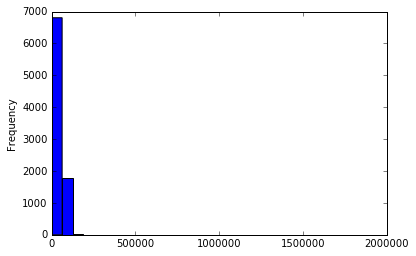

In [102]:
posts_df['post_impressions_organic_unique'].plot.hist(bins=30)
plt.show()

In [103]:
posts_df['post_impressions_organic_unique'].describe()

count    8.639000e+03
mean     4.464460e+04
std      4.047802e+04
min      0.000000e+00
25%      2.483950e+04
50%      3.911900e+04
75%      5.808000e+04
max      1.868728e+06
Name: post_impressions_organic_unique, dtype: float64

Note that the max value is orders of magnitude greater than the mean, so we have some outliers to deal with. We will 'winsorize' the series by reseting the outliers to perhaps the .5th and 99.5th percentile values.

In [104]:
posts_df['post_impressions_organic_unique'] = stats.mstats.winsorize(posts_df['post_impressions_organic_unique'],limits=[0.005, 0.005])

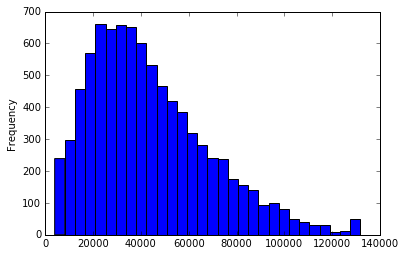

In [105]:
posts_df['post_impressions_organic_unique'].plot.hist(bins=30)
plt.show()

In [106]:
posts_df['post_impressions_organic_unique'].describe()

count      8639.000000
mean      43689.199444
std       24958.741127
min        3910.000000
25%       24839.500000
50%       39119.000000
75%       58080.000000
max      131686.000000
Name: post_impressions_organic_unique, dtype: float64

In [107]:
posts_df['post_impressions_organic_unique'].skew()

0.88174613024310544

We can see the distribution clearly exhibits positive skew. Let's try a log transformation

In [108]:
posts_df['log_piou'] = np.log(posts_df['post_impressions_organic_unique'])

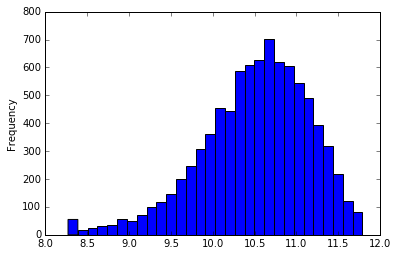

In [109]:
posts_df['log_piou'].plot.hist(bins=30)
plt.show()

In [110]:
posts_df['log_piou'].describe()

count    8639.000000
mean       10.502441
std         0.647361
min         8.271293
25%        10.120190
50%        10.574364
75%        10.969577
max        11.788176
Name: log_piou, dtype: float64

While we still have some negative skew, we are working with something much closer to a normal distribution.

## Feature Engineering

for starters, lets concatenate our three string columns into one so we can apply a single NLP related model for feature generation, and get rid of no longer needed columns.

In [111]:
posts_df['name_message_description'] =  posts_df['name'] + ' '+ posts_df['message'] + ' ' + posts_df['description']
posts_df = posts_df[['log_piou', 'name_message_description']]

In [112]:
posts_df.head()

,log_piou,name_message_description
0,8.271293,Students suspended for clothing displaying Con...
1,8.271293,Timeline Photos Seattle Seahawks' Russell Wils...
2,10.533642,"New forecasts still say mild winter, hot summe..."
3,8.724858,Amazon dangles $50 tablet computer to hook mor...
4,9.888475,Earth's record streak of record heat keeps on ...


### Topic Modeling

Let's try to abstract out the topic of each post and categorical features around it. We'll use Latent Dirichlet Allocation (LDA).

please see:

http://scikit-learn.org/stable/auto_examples/applications/plot_topics_extraction_with_nmf_lda.html#sphx-glr-auto-examples-applications-plot-topics-extraction-with-nmf-lda-py

Now we'll clean up the strings in the message and description columns for further processing,
We are going to remove a list of 'stop' words which are common words which carry little information. 
 

In [113]:



stop = set(stopwords.words('english'))
exclude = set(string.punctuation)
lemma = WordNetLemmatizer()
def clean(doc):
    stop_free = " ".join([i for i in doc.lower().split() if i not in stop])
    punc_free = ''.join(ch for ch in stop_free if ch not in exclude)
    normalized = " ".join(lemma.lemmatize(word) for word in punc_free.split())
    return normalized



In [114]:
posts_df['name_message_description'] = posts_df['name_message_description'].apply(lambda x: clean(x))
posts_df.head()

,log_piou,name_message_description
0,8.271293,student suspended clothing displaying confeder...
1,8.271293,timeline photo seattle seahawks russell wilson...
2,10.533642,new forecast still say mild winter hot summer ...
3,8.724858,amazon dangles 50 tablet computer hook consume...
4,9.888475,earth record streak record heat keep sizzling ...


First are going to treat each string as a bag of words and convert it to  need to a fixed length vector. 

In [200]:
documents = posts_df['name_message_description']
num_features = 1000

tf_vectorizer = CountVectorizer(max_df=0.95, min_df=2, max_features=num_features, stop_words='english')
tf = tf_vectorizer.fit_transform(documents)
tf_feature_names = tf_vectorizer.get_feature_names()



Now we train the LDA model to extract topics.

In [217]:
num_topics = 4

lda = LatentDirichletAllocation(n_topics=num_topics, max_iter=5, learning_method='online', learning_offset=50.,random_state=0).fit(tf)

/home/tmarble/anaconda3/lib/python3.5/site-packages/sklearn/decomposition/online_lda.py:294: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)


In [218]:

def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic {:d}:".format(topic_idx))
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))

no_top_words = 10
#display_topics(lda, tf_feature_names, no_top_words)


Lets apply the lda model to a sample of our post texts to understand what is happening. Basically we transform the text into a vector of length num_topics, whose values can be interpreted as the likely relevance to the topic in the model which shares the value's index.

In [219]:
msgs = posts_df['name_message_description'][:5]
msgs

0    student suspended clothing displaying confeder...
1    timeline photo seattle seahawks russell wilson...
2    new forecast still say mild winter hot summer ...
3    amazon dangles 50 tablet computer hook consume...
4    earth record streak record heat keep sizzling ...
Name: name_message_description, dtype: object

In [220]:
msgs_tpcs = lda.transform(tf_vectorizer.transform(msgs))
msgs_tpcs[2]

array([ 0.01296118,  0.36275048,  0.61314464,  0.01114371])

We can see that for this message, We can take the argmax of each row to get the most likely topic, but let's try working with the continuous values first and and them as features.

In [221]:
topic_arrs = lda.transform(tf_vectorizer.transform(documents))
topic_names=[]
for i in range(num_topics):
    topic_name = 'topic_{}'.format(str(i))
    topic_names.append(topic_name)




## Model Training and Validation

Now let's train a Random Forest model on the data as a starting point. Random Forest has some desirable properties such as handling feature interactions well and avoiding overfitting. We'll train on the first 80% of the data, and hold out the remaining 20% as a test set. As the underlying data is time-ordered, we will be careful to use the chronologically earlier data for training and vice versa.

We will then generate a set of metric tailored to regression problems, as we are predicting a continuous variable. These will give us a baseline for model tuning and further improvement throught the addtion of additional features, and to compare with different models.

In [222]:


M = len(posts_df)
num_train = int(M*.8)
x_scaler = StandardScaler()
y_scaler = StandardScaler()

X = pd.DataFrame(topic_arrs,columns=topic_names)
Y = posts_df['log_piou']

X_train = X[-num_train:]
X_train = x_scaler.fit_transform(X_train)

X_test = X[:-num_train]
X_test = x_scaler.transform(X_test)

Y_train = Y[-num_train:]
#Y_train = y_scaler.fit_transform(Y_train.reshape(-1,1))

Y_test = Y[:-num_train]
#Y_test = y_scaler.transform(Y_test.reshape(-1,1))


In [223]:

model = RandomForestRegressor().fit(X_train, Y_train)

In [224]:
y_pred = model.predict(X_test)

In [225]:

print('explained_variance', explained_variance_score(Y_test, y_pred))
print('neg_mean_absolute_error', mean_absolute_error(Y_test, y_pred) )
print('neg_mean_squared_error',  mean_squared_error(Y_test, y_pred)) 
print('neg_median_absolute_error', median_absolute_error(Y_test, y_pred)) 
print('r2', r2_score(Y_test, y_pred))

explained_variance -0.237131315187
neg_mean_absolute_error 0.53406544641
neg_mean_squared_error 0.454240667016
neg_median_absolute_error 0.447046271506
r2 -0.265645272896


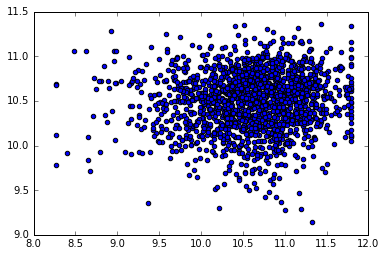

In [226]:
plt.scatter(Y_test, y_pred)



## Discussion and Where To Go Next

Random Forest, is a good default starting point, but is not necessarily the perfect model for this problem. Number one, the feature space we have generated is perhaps most similar to a 'one-hot encoded' vector, as it would be if we discretized the output from LDA. In this case there would be no feature interactions to consider, so much of the advantage would be moot. A better choice in this case might be a simple Logistic Regression model. 

One obvious starting point to expand out feature space is the 'created_time' variable, which lends itself to many feature extractions and transformations such as Hour of Day and Day of Week in addition to features related arrival rate of posts and changes thereof. As we expand the feature space, ensemble models such as Random Forest will see greater utility. Additionally, as we add features it will be important to discern the relative goodness of features, and for this the Feature Importance will be very useful.

Our model considers the information content of probabilistic topic assignment. A major flaw, though is that is does not consider nor take advantage of the intertemporal nature of this dataset, treating old and newer data equally. A more thoughtful solution to this problem might for example be a Recurrent Neural Network (RNN) perhaps implemented in Tensorflow, which would do a better job of iterativly 'learning' and model the time evolution of our signals. 

In reality we should appreciate the fluid and changing nature of topic 'hotness' over time, and making a quantitative metrics and predictions at the level of Topic, which we then use as a more intuitive feature. This could be done for example by for each of our topics, regressing historical values over a rolling time period of the topic relevance scores generated by LDA against historical organinc unique impressions (or whatever the best target metric may be), and further measuring changes in the regression coefficients to determine which way topics are trending. 

   

    
-
         
         
         

         
         